+-5.0462751855669055 = 152.72933820061863
+-3.6047897485954508 = 160.69890840340491
+0.9117203383434038 = -81.0117341011487
+0.858491935359531 = 144.7865576251798
+-6.146047111397017 = -173.80586283693745
+-8.966625548992265 = -171.90270158187633
+4.024904106977324 = -144.8864580708283
+-1.5224368910184864 = 124.30346862050997
+-8.948851715271932 = -183.9741776304147
+-4.0730694168632375 = 170.02390837165655
+-1.5210679550855666 = -155.80456196639344
+-8.958500167066521 = 165.00435414410018
+4.1396022536122885 = 175.9660432330048
+-2.1227688319118023 = 164.15594275709242
+6.388351469244689 = 166.65724040702298
+-3.662311217163296 = -173.05223412236398
+1.340653709222856 = -80.99992006687984
+4.145920383706713 = -127.04090103277272
+0.15662063074520916 = -144.62122543918613
+2.415954795132297 = -29.847088059869893
+3.9149735231268643 = -52.17792947995113
+-3.82268127408296 = 36.97542260031587
+-5.591913620358573 = -184.0624943693112
+1.8433173526353777 = 117.3852200262075
+0.59094837532

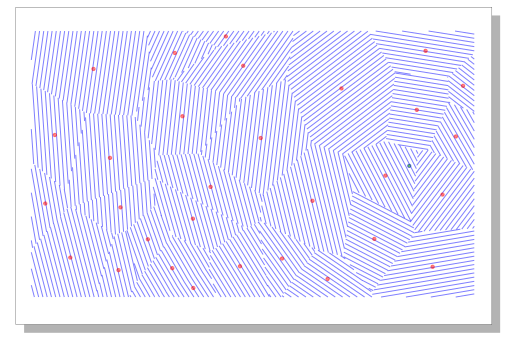

In [91]:
# coding=utf-8
import numpy as np
import matplotlib.pyplot as plt
import math
from math import atan2, degrees
from scipy.spatial import Voronoi
#from shapely.geometry import Polygon

import shapely.affinity as affinity
import shapely.geometry as geo
import shapely.ops as ops
import vsketch
from sklearn.neighbors import NearestNeighbors

vsk = vsketch.Vsketch()
vsk.size("6x4in", center=False)

DISPLAY_RATIO = 1.5
W = vsk.width
H = vsk.height

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.
    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.
    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.
    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

def distribute_points(heuristic):
    return heuristic()

def random_point_heuristic():
    points = np.random.random((30, 2))
    return list(map(lambda p: np.multiply(p, [W, H]), points))

def build_linear_fill_shape(polygon: geo.Polygon, center: geo.Point):
    lines = []
    centroid = polygon.centroid
    delta = geo.Point(centroid.x - center.x, centroid.y - center.y)
    angle = degrees(atan2(delta.y, delta.x))
    
    noise = vsk.noise(centroid.x, centroid.y)
    noise = np.interp(noise, [0, 1], [-50, 50])

    angle += noise
    print(f"+{noise} = {angle}")

    for x in np.arange(0, W, step=5):
        line = geo.LineString([(x, -H / 2), (x, H * 2)])
        line = affinity.rotate(line, angle, (centroid.x, centroid.y))
        lines.append(line)

    return geo.MultiLineString(lines)

def display(sketch):
    return sketch.display("matplotlib", fig_size=(6*DISPLAY_RATIO,4*DISPLAY_RATIO))


np.random.seed(24601)

# make up data points
points = distribute_points(random_point_heuristic)

# compute Voronoi tesselation
vor = Voronoi(points)

# plot
regions, vertices = voronoi_finite_polygons_2d(vor)

min_x = vor.min_bound[0] - 0.1
max_x = vor.max_bound[0] + 0.1
min_y = vor.min_bound[1] - 0.1
max_y = vor.max_bound[1] + 0.1

mins = np.tile((min_x, min_y), (vertices.shape[0], 1))
bounded_vertices = np.max((vertices, mins), axis=0)
maxs = np.tile((max_x, max_y), (vertices.shape[0], 1))
bounded_vertices = np.min((bounded_vertices, maxs), axis=0)

box = geo.Polygon([[min_x, min_y], [min_x, max_y], [max_x, max_y], [max_x, min_y]])

"""
fill = build_linear_fill_shape()
vsk.stroke(1)
vsk.geometry(fill)
"""

#"""
# colorize
center = geo.Point(W - 100, H / 2)
vsk.fill(3)
vsk.geometry(geo.Point(center).buffer(2))
vsk.noFill()

for region in regions:
    polygon = vertices[region]
    # Clipping polygon
    poly = geo.Polygon(polygon)
    poly = poly.intersection(box)
    clipped = geo.Polygon([p for p in poly.exterior.coords])

    vsk.stroke(1)
    vsk.noFill()
    fill = build_linear_fill_shape(clipped, center)
    masked = fill.intersection(clipped)
    vsk.geometry(masked)

    vsk.noStroke()
    vsk.fill(2)
    vsk.geometry(geo.Point(clipped.centroid).buffer(2))
    #break
#"""

display(vsk)